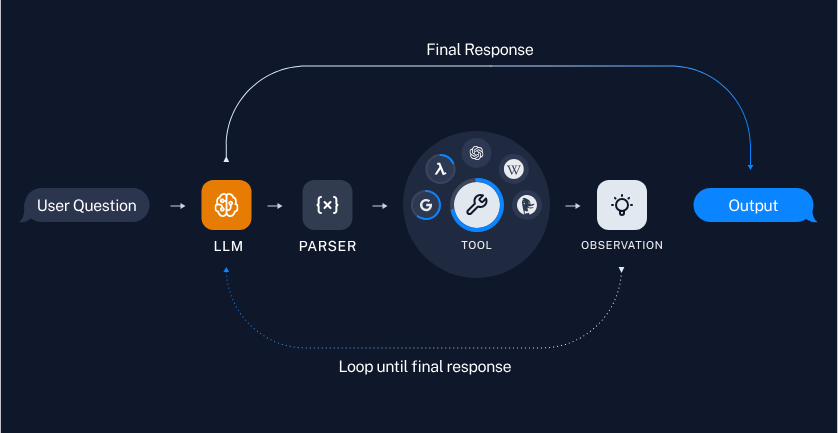  

In [1]:
%load_ext dotenv
%dotenv

In [2]:
%pip install --quiet cohere


[notice] A new release of pip is available: 23.2.1 -> 24.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [3]:
import os

tavily_api_key = os.getenv('TAVILY_API_KEY')
cohere_api_key = os.getenv('COHERE_API_KEY')

In [ ]:
# define the `web_search` tool.
from tavily import TavilyClient

tavily_client = TavilyClient(api_key=tavily_api_key)

def web_search(query: str) -> list[dict]:
    results = tavily_client.search(query, max_results=3)["results"]
    return results

web_search_tool = {
    "type": "function",
    "function": {
        "name": "web_search",
        "description": "performs a web search with the specified query",
        "parameters": {
            "type": "object",
            "properties": {
                "query": {
                    "type": "str",
                    "description": "the query to look up"
                }
            },
            "required": ["query"]
        }
    }
}


In [ ]:
import json
import cohere
co = cohere.ClientV2(api_key=cohere_api_key)

# 1 - Add the user message
message = "Who is the mayor of the capital of Ontario?"
messages = [{"role": "user", "content": message}]

# 2 - Model generates tool calls, if any
model = "command-r-plus-08-2024"
res = co.chat(model=model, messages=messages, tools=[web_search_tool])

# As long as the model sends back tool_calls,
# keep invoking tools and sending the results back to the model
while res.message.tool_calls:
    print("\nTool plan:")
    print(
        res.message.tool_plan
    )  # This will be an observation and a plan with next steps

    print("\nTool calls:")
    for tc in res.message.tool_calls:
        print(f"Tool name: {tc.function.name} | Parameters: {tc.function.arguments}")

    messages.append(
        {
            "role": "assistant",
            "tool_calls": res.message.tool_calls,
            "tool_plan": res.message.tool_plan,
        }
    )

    # 3 - Execute tools based on the tool calls generated by the model
    print("\nTool results:")
    for tc in res.message.tool_calls:
        tool_result = web_search(**json.loads(tc.function.arguments))
        print(tool_result)
        tool_content = []
        for data in tool_result:
            tool_content.append({"type": "document", "document": {"data": json.dumps(data)}})
            # Optional: add an "id" field in the "document" object, otherwise IDs are auto-generated
        messages.append(
            {"role": "tool", "tool_call_id": tc.id, "content": tool_content}
        )

    # 4 - Model either generates more tool calls or returns a response
    res = co.chat(model=model, messages=messages, tools=[web_search_tool])

print("\nResponse:")
print(res.message.content[0].text)

if res.message.citations:
    print("\nCitations:")
    for citation in res.message.citations:
        print(citation, "\n")



Tool plan:
I will search for the capital of Ontario and then search for the mayor of that city.

Tool calls:
Tool name: web_search | Parameters: {"query":"capital of ontario"}

Tool results:
[{'title': 'Ottawa - Wikipedia', 'url': 'https://en.wikipedia.org/wiki/Ottawa', 'content': "Jim Watson, the last mayor of Ottawa before amalgamation, was re-elected in the 2010 election.[110]\nIn October 2012, the City Council approved the final Lansdowne Park plan, an agreement with the Ottawa Sports and Entertainment Group that saw a new stadium, increased green space and housing and retail added to the site.[111][112] In December 2012, City Council voted unanimously to move forward with the Confederation Line, a 12.5\xa0km (7.8\xa0mi) light rail transit line, which was opened on 14 September 2019.[113]\nGeography[edit]\nNeighbourhoods[edit]\nThe present-day city of Ottawa consists of the historic main urban area, as well as other urban, suburban and rural areas within the city's post-amalgamati